In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.backends.cudnn.benchmark=True #optimizes algo for gpu

### Data Processing 

Return:   
cats -> dict mapping category id to category name  
trn_fns -> dict mapping image id to filename  
trn_ids -> list of ids for each image   
trn_anno -> dict mapping image id to tuple containing bbox and cat_id (hint collections.defaultdict)  

functions to:  
->show_img  
->draw_outline  
->draw_rect  
->draw_text   
->draw_img  
->draw_idx  


In [3]:
PATH = Path("../../Data/Pascal")
JPEG = 'VOCdevkit/VOC2007/JPEGImages'

IMAGE_PATH = PATH/JPEG

trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()


dict_keys(['images', 'type', 'annotations', 'categories'])

In [4]:
IMAGES, _, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'categories']
FILE_NAME, ID, IMAGE_ID, BBOX, NAME, CAT_ID= 'file_name', 'id', 'image_id', 'bbox', 'name', 'category_id'

cats = {o[ID]:o[NAME] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]} 
trn_ids = [o[ID] for o in trn_j[IMAGES]] 


In [5]:
def bbox_tonp(b):
    return np.array([b[1], b[0], b[1]+b[3]-1, b[0]+b[2]-1])

def bbox_toOG(b):
    return np.array([b[1], b[0], b[3]-b[1]+1, b[2]-b[0]+1])
        
def trn_anno_helper(trn):
    builder = collections.defaultdict(lambda:[])
    for o in trn[ANNOTATIONS]:
        if not o['ignore']:
            b = bbox_tonp(o[BBOX])
            builder[o[IMAGE_ID]].append((b, o[CAT_ID]))
    return builder

trn_anno = trn_anno_helper(trn_j)

### Helper Functions: Plotting, CMAPS, and Showing Ground Truth

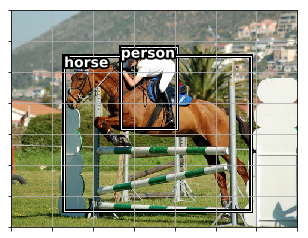

In [6]:
def show_img(image, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_xticks(np.linspace(0,len(image[0]),8))
    ax.set_yticks(np.linspace(0,len(image),8))
    ax.grid()#create grid 
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax 
    
def draw_outline(text,lw=4):
    text.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'),
                       patheffects.Normal()])
    
def draw_rect(ax,bb, color='white'):
    patch = ax.add_patch(patches.Rectangle(bb[:2], *bb[-2:],fill=False,
                                           color=color))
    draw_outline(patch, 4) #patches must be drawn 
    
def draw_text(ax, xy, text, sz=14, color='white'):
    text = ax.text(*xy, text, verticalalignment='top',
                   fontsize=sz, color=color, weight='bold')
    draw_outline(text)

def draw_img(image, annos):
    ax = show_img(image)
    for box,cat in annos:
        b = bbox_toOG(box)
        draw_rect(ax,b)
        draw_text(ax,b[:2], cats[cat], sz=14)

def draw_idx(i):
    image = open_image(IMAGE_PATH/trn_fns[i])
    draw_img(image,trn_anno[i])
    
#e.g.
draw_idx(17)


In [7]:
import matplotlib.cm as cmx 
import matplotlib.colors as mcolors 
from cycler import cycler 

def get_cmap(N):
    """
    given a max normalization number, normalize colors between interval
    vmin=0 and vmax=N. Then map the normalized color values into RGBA
    """
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap="Set3").to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
#for N colors create a list using cmap which returns normalized RGBA colors
color_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    #happens for a single image 
    bb = [bbox_toOG(o) for o in bbox.reshape(-1,4)] 
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=color_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=color_list[i%num_colr])

class ConcatDatasets(Dataset):
    def __init__(self,ds,y2):
        self.ds, self.y2 = ds, y2
    def __len__(self):
        return len(self.ds)
    def __getitem__ (self, i):
        x,y = self.ds[i]
        return (x,(y,self.y2[i]))

### Setup Multiclass Classification CSV file

Create multiclass csvs such that a filename points to a list of classes

In [8]:
MC_CSV = PATH/'tmp/mc.csv'


#creates a list of sets, with each set repping the classes for a traing id
mc = [set([cats[tpl[1]] for tpl in trn_anno[i]]) for i in trn_ids]

#creates a list converting each set into a string
mcs2 = [" ".join(p) for p in mc]

#save to df
df =pd.DataFrame({'fn':[trn_fns[i] for i in trn_ids], 'clas':mcs2},
                 columns=['fn','clas'])

df.to_csv(MC_CSV, index=False)


### Multiclass Classifier Training

In [9]:
#create a resnet 
f_model = resnet34
bs = 64 
sz = 224 

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEG, MC_CSV, bs=bs, tfms=tfms, )

In [10]:
learner = ConvLearner.pretrained(f_model, md)
learner.opt_fn = optim.Adam

In [11]:
lrf=learner.lr_find(1e-5,100)
learner.sched.plot()

  0%|          | 0/32 [00:00<?, ?it/s]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Documents\Learning\FastAI Coursework\fastai\dataloader.py", line 88, in __iter__
    for batch in e.map(self.get_batch, c):
  File "C:\Users\Raed\Anaconda3\envs\fastai\lib\concurrent\futures\_base.py", line 586, in result_iterator
    yield fs.pop().result()
  File "C:\Users\Raed\Anaconda3\envs\fastai\lib\concurrent\futures\_base.py", line 427, in result
    self._condition.wait(timeout)
  File "C:\Users\Raed\Anaconda3\envs\fastai\lib\threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Raed\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-805a4ca54a01>", line 1, in <module>
    lrf=learner.lr_find(1e-5,100)
  File "D:\Documents\Learning\FastAI Coursework\fastai\learner.py", 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Documents\Learning\FastAI Coursework\fastai\dataloader.py", line 88, in __iter__
    for batch in e.map(self.get_batch, c):
  File "C:\Users\Raed\Anaconda3\envs\fastai\lib\concurrent\futures\_base.py", line 586, in result_iterator
    yield fs.pop().result()
  File "C:\Users\Raed\Anaconda3\envs\fastai\lib\concurrent\futures\_base.py", line 427, in result
    self._condition.wait(timeout)
  File "C:\Users\Raed\Anaconda3\envs\fastai\lib\threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Raed\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-805a4ca54a01>", line 1, in <module>
    lrf=learner.lr_find(1e-5,100)
  File "D:\Documents\Learning\FastAI Coursework\fastai\learner.py", 


KeyboardInterrupt



In [ ]:
lr = 2e-2
learner.fit(lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

In [ ]:
lrs = np.array([lr/100, lr/10, lr])
learner.freeze_to(-2)
learner.lr_find(lrs/1000)
learner.sched.plot()

In [ ]:
#so the following will take vary between max and min lrs between 5 cycles 
learner.fit(lrs/10,n_cycle=1, cycle_len=5, use_clr=(32,5))


In [ ]:
learner.save('multi-class classifier')


In [12]:
learner.load('multi-class classifier')

In [13]:
y = learner.predict() #predictions for entire validation set 
x, _ = next(iter(md.val_dl))
x = to_np(x) #so no longer tensor 

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

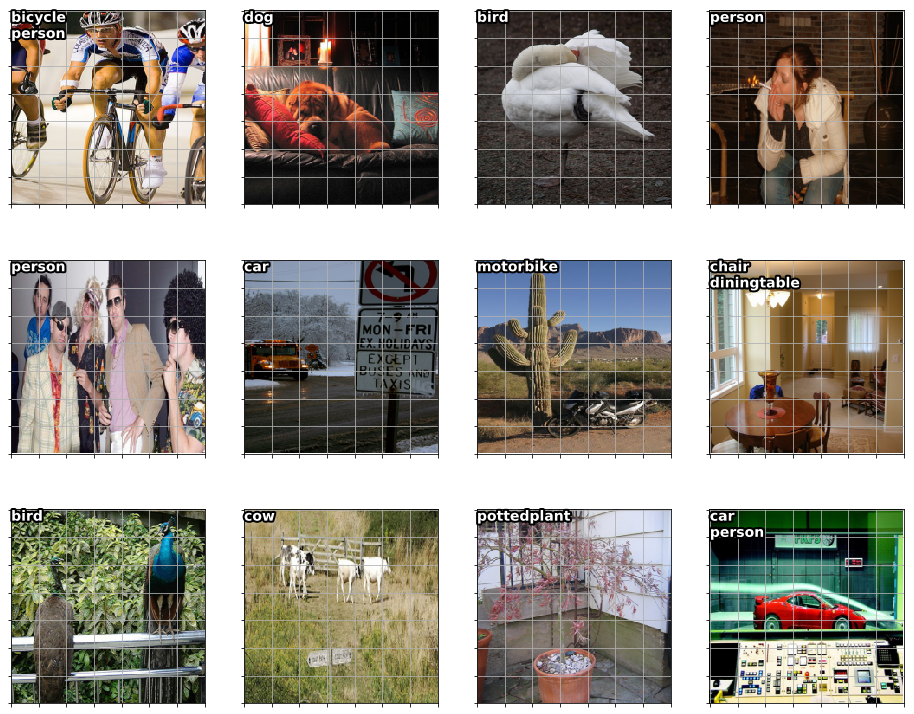

In [14]:
fig, axes = plt.subplots(3,4, figsize=(16,13))
for i, a in enumerate(axes.flat):
    img = md.val_ds.denorm(x)[i]
    show_img(img, ax=a)
    pred = np.nonzero(y[i]>0.4)[0]
    text = "\n".join([md.classes[i] for i in pred])
    draw_text(a,(0,0), text)
plt.tight_layout

### Setup CSVs for Multi Class Detection

-mc creates a list containing cat names for all trn_ids  
-id2cat creates a list containing all the category names  
-cat2id creates a dict mapping cat id a cat name  
-mcs creates an array of arrays that represent the cat ids for all cat names in mc  
-mbb creates nested list of bounding boxes for each image id   
-mbbs takees the above nest list and makes them into a list of strings  

In [9]:
CLAS_CSV = PATH/'tmp/clas.csv' #maps fn to classes
MBB_CSV = PATH/'tmp/mbb.csv' #maps fn to bboxes 

f_model = resnet34
sz = 224 #image size 
bs = 64 #batch size for network 

In [10]:
mc = [[cats[i[1]] for i in trn_anno[j]]for j in trn_ids]
id2cat = list(cats.values())
cat2id = {j:i for i,j in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[i] for i in o ])for o in mc])
mbb = [np.concatenate([i[0] for i in trn_anno[o]]) for o in trn_ids]
mbbs = [" ".join(str(i) for i in o) for o in mbb]

In [11]:
val_idx = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idx, mcs)

In [12]:
#note because you found mbbs using trn_ids you must order fns in that order too
df = pd.DataFrame({'fn':[trn_fns[o] for o in trn_ids], 
                  'bboxes':mbbs}, columns=['fn', 'bboxes'])

#to_csv is a method for DataFrame 
df.to_csv(MBB_CSV,index=False)

In [13]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, aug_tfms=aug_tfms, crop_type=CropType.NO,
                      tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEG, MBB_CSV, bs=bs, tfms=tfms, 
                                 continuous=True, num_workers=4)

In [14]:
trn_ds2 = ConcatDatasets(md.trn_ds, trn_mcs)
val_ds2 = ConcatDatasets(md.val_ds, val_mcs)

md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [15]:
x,y = to_np(next(iter(md.trn_dl)))
x = md.trn_ds.ds.denorm(x) #denorm the minibatch 

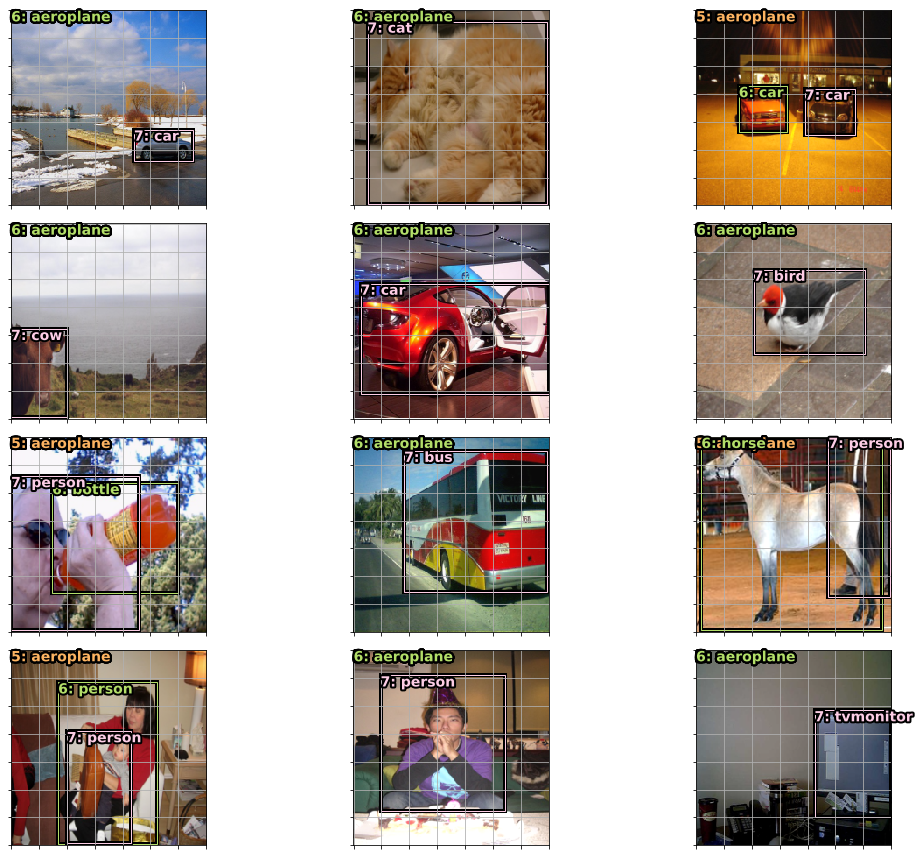

In [16]:
fig, axes = plt.subplots(4,3,figsize=(16,12))
for i, ax in enumerate(axes.flat):
    show_ground_truth(ax,x[i],y[0][i], y[1][i])
plt.tight_layout()

### Model Setup
Predict object in each cell of a 4x4 grid 

In [17]:
anc_grid = 4
k = 1

#to CENTER grids properly 
anc_offset = 1 /(anc_grid*2)

#values for cetner points of grids 
#repeating each x value 4 times as it has 4 y values 
anc_x = np.repeat(np.linspace(anc_offset,1-anc_offset, anc_grid), anc_grid)
#stack y values so they get called for each x value 
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset,anc_grid),anc_grid)

#show center value for each grid once (total 16)
anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis =1), (1,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

#4x4 grid, total 16 grids 
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1),requires_grad=False).float()

grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])


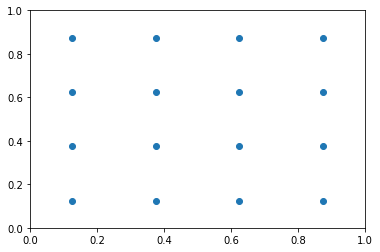

In [18]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [19]:
n_clas = len(id2cat) + 1
n_act = k*(4+n_clas)

### Architecture 

In [20]:
class StdConv(nn.Module):
    """
    Standard Conv layer that performs:
    conv2d with 3 filters, padding =1, and stride of 2 as default 
    batchnorm 2d 
    dropout
    """
    def __init__(self, ni, no, stride=2, p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(ni,no,kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(no)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x, k):
    """
    helper function to flatten the output from a conv layer 
    so that output is of size (bs,-1, nf//k) where nf is the number of 
    filters. This is to match what the loss function is expecting. 
    
    E.G. If you have 12 filters, x.size() = 64,12,#,#
    Then output would be with k=1, bs,#,#,12. 
    """
    bs, nf, _, _ = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [21]:
class OutConv(nn.Module):
    """
    The conv layer for the head of our network, seperate the logic for bbox and 
    clasifier into two seperate conv layers, that are flattened and returned. 
    """
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, k*(len(cat2id)+1), 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, k*4, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
            return [flatten_conv(self.oconv1(x), self.k),
                   flatten_conv(self.oconv2(x), self.k)]
        
class SSD_Head(nn.Module):
    """
    Custom head for the network that uses the above defined layers 
    to perform the final computations 
    """
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv1 = StdConv(512, 256, stride=1) #no change in size (stride1)
        self.sconv2 = StdConv(256, 256) #output is 4x4 as stride is 2 
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.sconv2(self.sconv1(self.drop(x)))
        return self.out(x)
    

In [22]:
custom_head = SSD_Head(k, -3.)
model = ConvnetBuilder(f_model, 0,0,0, custom_head=custom_head)
learn = ConvLearner(md,model)
learn.opt_fn = optim.Adam

### Loss Function and Helpers

We have 16 sets of activations, each has 4 bounding box coordinates and c+1 class probabilties. We must decide if these activations are close or far from the object closes to this grid cell. While if nothing is there we can just predict background. 


In [23]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [24]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [40]:
def actn_to_bb(actn, anchors):
    #stick through tanh to get -1-1 range
    actn_bbs = torch.tanh(actn)
    #grab actual position of anch centers and shift by up to 50% of grid size 
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    #grab actual height width and shrink or increase from 1.50 to 0.5 times 
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    #convert to corners 
    return hw2corners(actn_centers, actn_hw)

def get_y(bbox,clas):
    #removes any fake padding bboxes 
    bbox = bbox.view(-1,4)/sz #reize 
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep] 

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1) #which anchorb overlapped most with gt
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0) #anchor overlaps for each gt 
    gt_overlap[prior_idx] = 1.99 #gt_overlap is set high for above 
    for i,o in enumerate(prior_idx): gt_idx[o] = i #
    return gt_overlap,gt_idx

In [44]:
def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs    

### Training 

In [28]:
x,y = next(iter(md.val_dl))
x,y = V(x), V(y)


In [29]:
for i,o in enumerate(y): y[i] = o.cuda()
learn.model.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [30]:
anchors = anchors.cuda()
grid_sizes = grid_sizes.cuda()
anchor_cnr = anchor_cnr.cuda()

batch = learn.model(x)
ssd_loss(batch, y, True)
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])


 0.1947
 0.1168
 0.2652
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2885
 0.0888
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.9027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.1608
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3237
 0.2153
 0.2558
 0.2013
 0.2526
 0.0485
 0.0879
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3258
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2704
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.4538
 0.1897
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.1527
 0.1863
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3249
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.0642
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2418
 0.2337
 0.2590
[torch.cuda.FloatTensor of size 3 (GPU 0)]


1.00000e-02 *
  8.4642
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3652
 0.1377
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.5146
  5.739

In [ ]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [ ]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))
learn.save('0')

In [31]:
learn.load('0')

### Testing

In [32]:
x,y = next(iter(md.val_dl))
x,y = V(x), V(y)
learn.model.eval() #puts model into evaluation mode 
batch = learn.model(x) #evals a batch 
b_clas, b_bb = batch
b_clas.size(), b_bb.size() #expect 64, 16 grids, 21 classes and 64, 16, 4

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [33]:
i = 7
b_clas_i, b_bb_i = b_clas[i], b_bb[i]
img_i = md.val_ds.ds.denorm(x)[i]
bbox, clas = get_y(y[0][i], y[1][i]) #gts 
print (bbox, clas) #notice how bbox is between 0 and 1!

Variable containing:
 0.6786  0.4866  0.9911  0.6250
 0.7098  0.0848  0.9911  0.5491
 0.5134  0.8304  0.6696  0.9063
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]
 Variable containing:
  8
 10
 17
[torch.cuda.LongTensor of size 3 (GPU 0)]



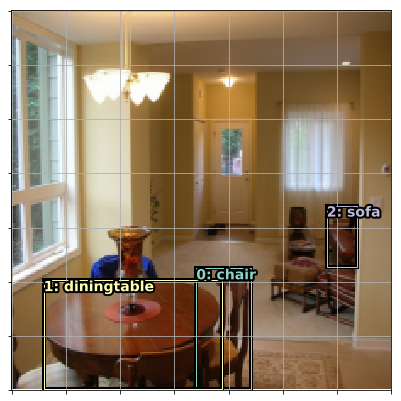

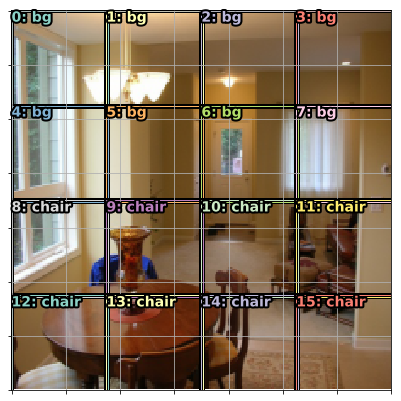

In [34]:
def torch_gt(ax, im, bbox, clas, prs=None, thresh = 0.4):
    """
    Call show_ground_truth after converting bbox, clas, and prs to numpy arrays
    """
    return show_ground_truth(ax, im, to_np((bbox*224).long()), to_np(clas), 
                             to_np(prs) if prs is not None else None,
                             thresh)

fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, img_i, bbox, clas)


fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, img_i, anchor_cnr, b_clas_i.max(1)[1])

### More Anchors 

In [46]:
# different sized anchors 
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])



Variable containing:
 0.1250  0.1250  0.1750  0.1750
 0.1250  0.1250  0.1750  0.0875
 0.1250  0.1250  0.0875  0.1750
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.1250  0.2500  0.1250
 0.1250  0.1250  0.1250  0.2500
 0.1250  0.1250  0.3250  0.3250
 0.1250  0.1250  0.3250  0.1625
 0.1250  0.1250  0.1625  0.3250
 0.1250  0.3750  0.1750  0.1750
 0.1250  0.3750  0.1750  0.0875
 0.1250  0.3750  0.0875  0.1750
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.3750  0.2500  0.1250
 0.1250  0.3750  0.1250  0.2500
 0.1250  0.3750  0.3250  0.3250
 0.1250  0.3750  0.3250  0.1625
 0.1250  0.3750  0.1625  0.3250
 0.1250  0.6250  0.1750  0.1750
 0.1250  0.6250  0.1750  0.0875
 0.1250  0.6250  0.0875  0.1750
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.6250  0.2500  0.1250
 0.1250  0.6250  0.1250  0.2500
 0.1250  0.6250  0.3250  0.3250
 0.1250  0.6250  0.3250  0.1625
 0.1250  0.6250  0.1625  0.3250
 0.1250  0.8750  0.1750  0.1750
 0.1250  0.8750  0.1750  0.0875
 0.1250  0.8750  0.0875  0.1750
 0.1250  0.8750  0.

### Model Architecture: More Anchor Boxes
More anchor boxes would imply that we must modify our final activations accordingly 


In [49]:
drop = 0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, p=drop)
        self.sconv1 = StdConv(256,256, p=drop)
        self.sconv2 = StdConv(256,256, p=drop)
        self.sconv3 = StdConv(256,256, p=drop)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
    
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [50]:
head_reg4 = SSD_MultiHead(k,-4.)
models = ConvnetBuilder(f_model, 0,0,0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam


epoch      trn_loss   val_loss                           
    0      443.692913 708755.973



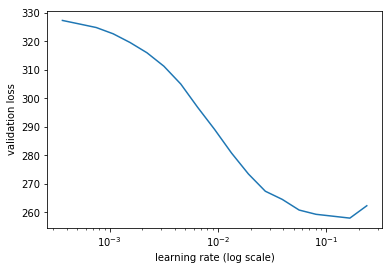

In [51]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

epoch      trn_loss   val_loss                           
    0      160.826406 143.916635
    1      126.561317 101.326416                         
    2      108.19523  91.87348                           
    3      95.635372  87.214101                           



epoch      trn_loss   val_loss                            
    0      89.631878  104.305635
    1      84.925667  85.305682                           
    2      77.240472  78.386803                           
    3      69.841276  76.225529                           



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


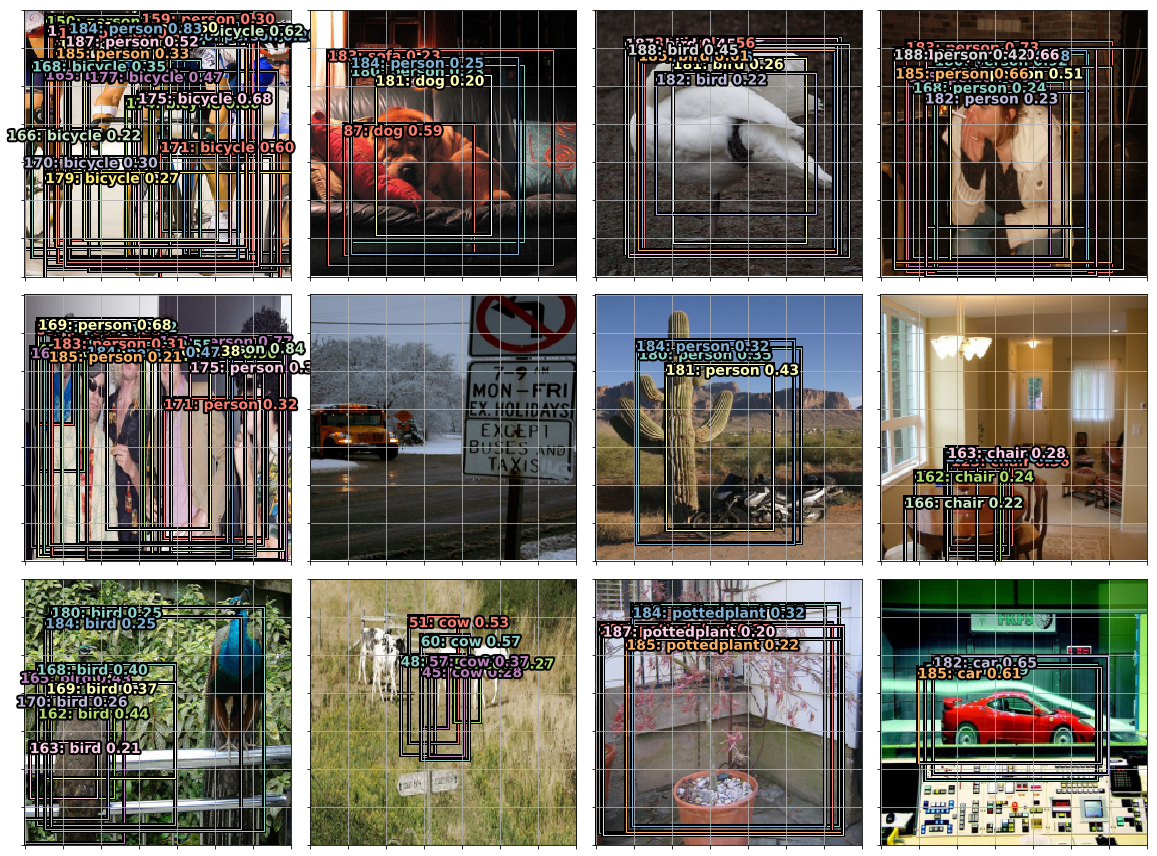

In [52]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))
learn.save('tmp')

learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], 
             b_clas[idx].max(1)[0].sigmoid(), 0.2)
plt.tight_layout()

In [53]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

 94%|█████████▍| 30/32 [00:28<00:01,  1.04it/s, loss=135] 

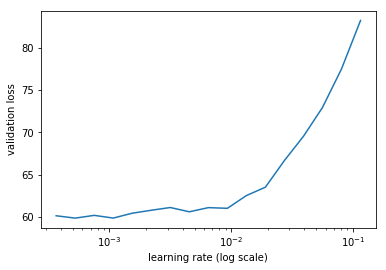

In [54]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [55]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

learn.save('fl0')
learn.load('fl0')
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      72.67999   138.801513
    1      91.511681  135.421112                          
    2      88.75282   93.266576                           
    3      82.100644  93.60741                            
    4      74.553733  84.435848                           
    5      67.755921  83.04919                            
    6      61.978586  80.679741                           
    7      56.611239  81.429021                           
    8      52.14873   79.117548                           
    9      48.452378  78.426062                           


epoch      trn_loss   val_loss                            
    0      43.900571  79.18546  
    1      44.006156  82.966286                           
    2      43.330093  81.71334                            
    3      41.872434  82.470356                           
    4      40.496598  82.239539                           
    5      38.895217  81.107173                           
    6      37.06617   83.448567                           
    7      35.581819  82.393321                           
    8      34.240562  81.415261                           
    9      33.05639   82.276294                           


[array([82.27629])]

In [56]:
learn.save('drop4')
learn.load('drop4')
plot_results(0.75)

NameError: name 'plot_results' is not defined

### Pull Out Interesting Only : Non Max Supression

If bboxes overlap by a certain amount and also predict same class we will know it is the same

In [ ]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  
        # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)
for i in range(12): show_nmf(i)